<a href="https://colab.research.google.com/github/haseebhijazi/ufc_match_prediction/blob/main/ufc_match_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTS**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

**LOADING AND UNDERSTANDING DATASET**

In [2]:
path = "/content/Data/medium_dataset.csv"
data = pd.read_csv(path)

data.rename(columns={
                   'r_kd':'r_knockdowns',
                   'b_kd':'b_knockdowns',
                   'r_str':'r_strikes',
                   'b_str':'b_strikes',
                   'r_td':'r_takedowns',
                   'b_td':'b_takedowns',
                   'r_sub':'r_submission',
                   'b_sub':'b_submission'}, inplace=True)

data.head()

,event,date,location,r_fighter,b_fighter,status,r_knockdowns,b_knockdowns,r_strikes,b_strikes,r_takedowns,b_takedowns,r_submission,b_submission,weight_class,method,method_detailed,round,time
0,UFC Fight Night: Ribas vs. Namajunas,3/23/2024,"Las Vegas, Nevada, USA",Rose Namajunas,Amanda Ribas,win,0.0,0.0,93.0,83.0,1.0,4.0,0.0,0.0,Women's Flyweight,U-DEC,NaN,5.0,5:00
1,UFC Fight Night: Ribas vs. Namajunas,3/23/2024,"Las Vegas, Nevada, USA",Karl Williams,Justin Tafa,win,0.0,0.0,40.0,21.0,7.0,0.0,1.0,0.0,Heavyweight,U-DEC,NaN,3.0,5:00
2,UFC Fight Night: Ribas vs. Namajunas,3/23/2024,"Las Vegas, Nevada, USA",Edmen Shahbazyan,AJ Dobson,win,1.0,0.0,27.0,15.0,1.0,0.0,0.0,0.0,Middleweight,KO/TKO,Punches,1.0,4:33
3,UFC Fight Night: Ribas vs. Namajunas,3/23/2024,"Las Vegas, Nevada, USA",Payton Talbott,Cameron Saaiman,win,1.0,0.0,79.0,31.0,0.0,0.0,0.0,0.0,Bantamweight,KO/TKO,Punches,2.0,0:21
4,UFC Fight Night: Ribas vs. Namajunas,3/23/2024,"Las Vegas, Nevada, USA",Youssef Zalal,Billy Quarantillo,win,0.0,0.0,33.0,10.0,2.0,0.0,2.0,0.0,Featherweight,SUB,Rear Naked Choke,2.0,1:50


In [3]:
data.shape

(7582, 19)

In [4]:
data.columns

Index(['event', 'date', 'location', 'r_fighter', 'b_fighter', 'status',
       'r_knockdowns', 'b_knockdowns', 'r_strikes', 'b_strikes', 'r_takedowns',
       'b_takedowns', 'r_submission', 'b_submission', 'weight_class', 'method',
       'method_detailed', 'round', 'time'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7582 entries, 0 to 7581
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   event            7497 non-null   object 
 1   date             7497 non-null   object 
 2   location         7497 non-null   object 
 3   r_fighter        7497 non-null   object 
 4   b_fighter        7497 non-null   object 
 5   status           7582 non-null   object 
 6   r_knockdowns     7476 non-null   float64
 7   b_knockdowns     7476 non-null   float64
 8   r_strikes        7476 non-null   float64
 9   b_strikes        7476 non-null   float64
 10  r_takedowns      7476 non-null   float64
 11  b_takedowns      7476 non-null   float64
 12  r_submission     7476 non-null   float64
 13  b_submission     7476 non-null   float64
 14  weight_class     7497 non-null   object 
 15  method           7497 non-null   object 
 16  method_detailed  3836 non-null   object 
 17  round         

**DATA CLEANING**

In [6]:
data.isnull().sum()

event                85
date                 85
location             85
r_fighter            85
b_fighter            85
status                0
r_knockdowns        106
b_knockdowns        106
r_strikes           106
b_strikes           106
r_takedowns         106
b_takedowns         106
r_submission        106
b_submission        106
weight_class         85
method               85
method_detailed    3746
round                85
time                 85
dtype: int64

In [7]:
data.dropna(inplace=True)
data.drop(['event', 'date', 'weight_class', 'method', 'method_detailed'], axis = 1, inplace = True)

In [8]:
data.shape

(3825, 14)

In [9]:
data.isnull().sum()

location        0
r_fighter       0
b_fighter       0
status          0
r_knockdowns    0
b_knockdowns    0
r_strikes       0
b_strikes       0
r_takedowns     0
b_takedowns     0
r_submission    0
b_submission    0
round           0
time            0
dtype: int64

In [10]:
data.columns

Index(['location', 'r_fighter', 'b_fighter', 'status', 'r_knockdowns',
       'b_knockdowns', 'r_strikes', 'b_strikes', 'r_takedowns', 'b_takedowns',
       'r_submission', 'b_submission', 'round', 'time'],
      dtype='object')

**DATA PRE-PROCESSING**

In [11]:
data_lose = data.copy()

data_lose['r_fighter'], data_lose['b_fighter'] = data['b_fighter'], data['r_fighter']
data_lose['r_knockdowns'], data_lose['b_knockdowns'] = data['b_knockdowns'], data['r_knockdowns']
data_lose['r_strikes'], data_lose['b_strikes'] = data['b_strikes'], data['r_strikes']
data_lose['r_takedowns'], data_lose['b_takedowns'] = data['b_takedowns'], data['r_takedowns']
data_lose['r_submission'], data_lose['b_submission'] = data['b_submission'], data['r_submission']

data_lose['status'] = 'lose'

data = pd.concat([data, data_lose], ignore_index=True)

In [12]:
le = LabelEncoder()
for col in data.columns:
  if data[col].dtype == 'object':
    data[col] = le.fit_transform(data[col])

data.head(3)

,location,r_fighter,b_fighter,status,r_knockdowns,b_knockdowns,r_strikes,b_strikes,r_takedowns,b_takedowns,r_submission,b_submission,round,time
0,79,615,1,1,1.0,0.0,27.0,15.0,1.0,0.0,0.0,0.0,1.0,280
1,79,1600,297,1,1.0,0.0,79.0,31.0,0.0,0.0,0.0,0.0,2.0,16
2,79,2106,214,1,0.0,0.0,33.0,10.0,2.0,0.0,2.0,0.0,2.0,117


In [13]:
data.tail(3)

,location,r_fighter,b_fighter,status,r_knockdowns,b_knockdowns,r_strikes,b_strikes,r_takedowns,b_takedowns,r_submission,b_submission,round,time
7647,47,518,1027,0,0.0,0.0,4.0,11.0,0.0,1.0,0.0,0.0,1.0,62
7648,47,1664,1582,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,53
7649,47,1819,1815,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,15


**DATA ANALYSIS AND VISUALIZATION**

<Axes: >

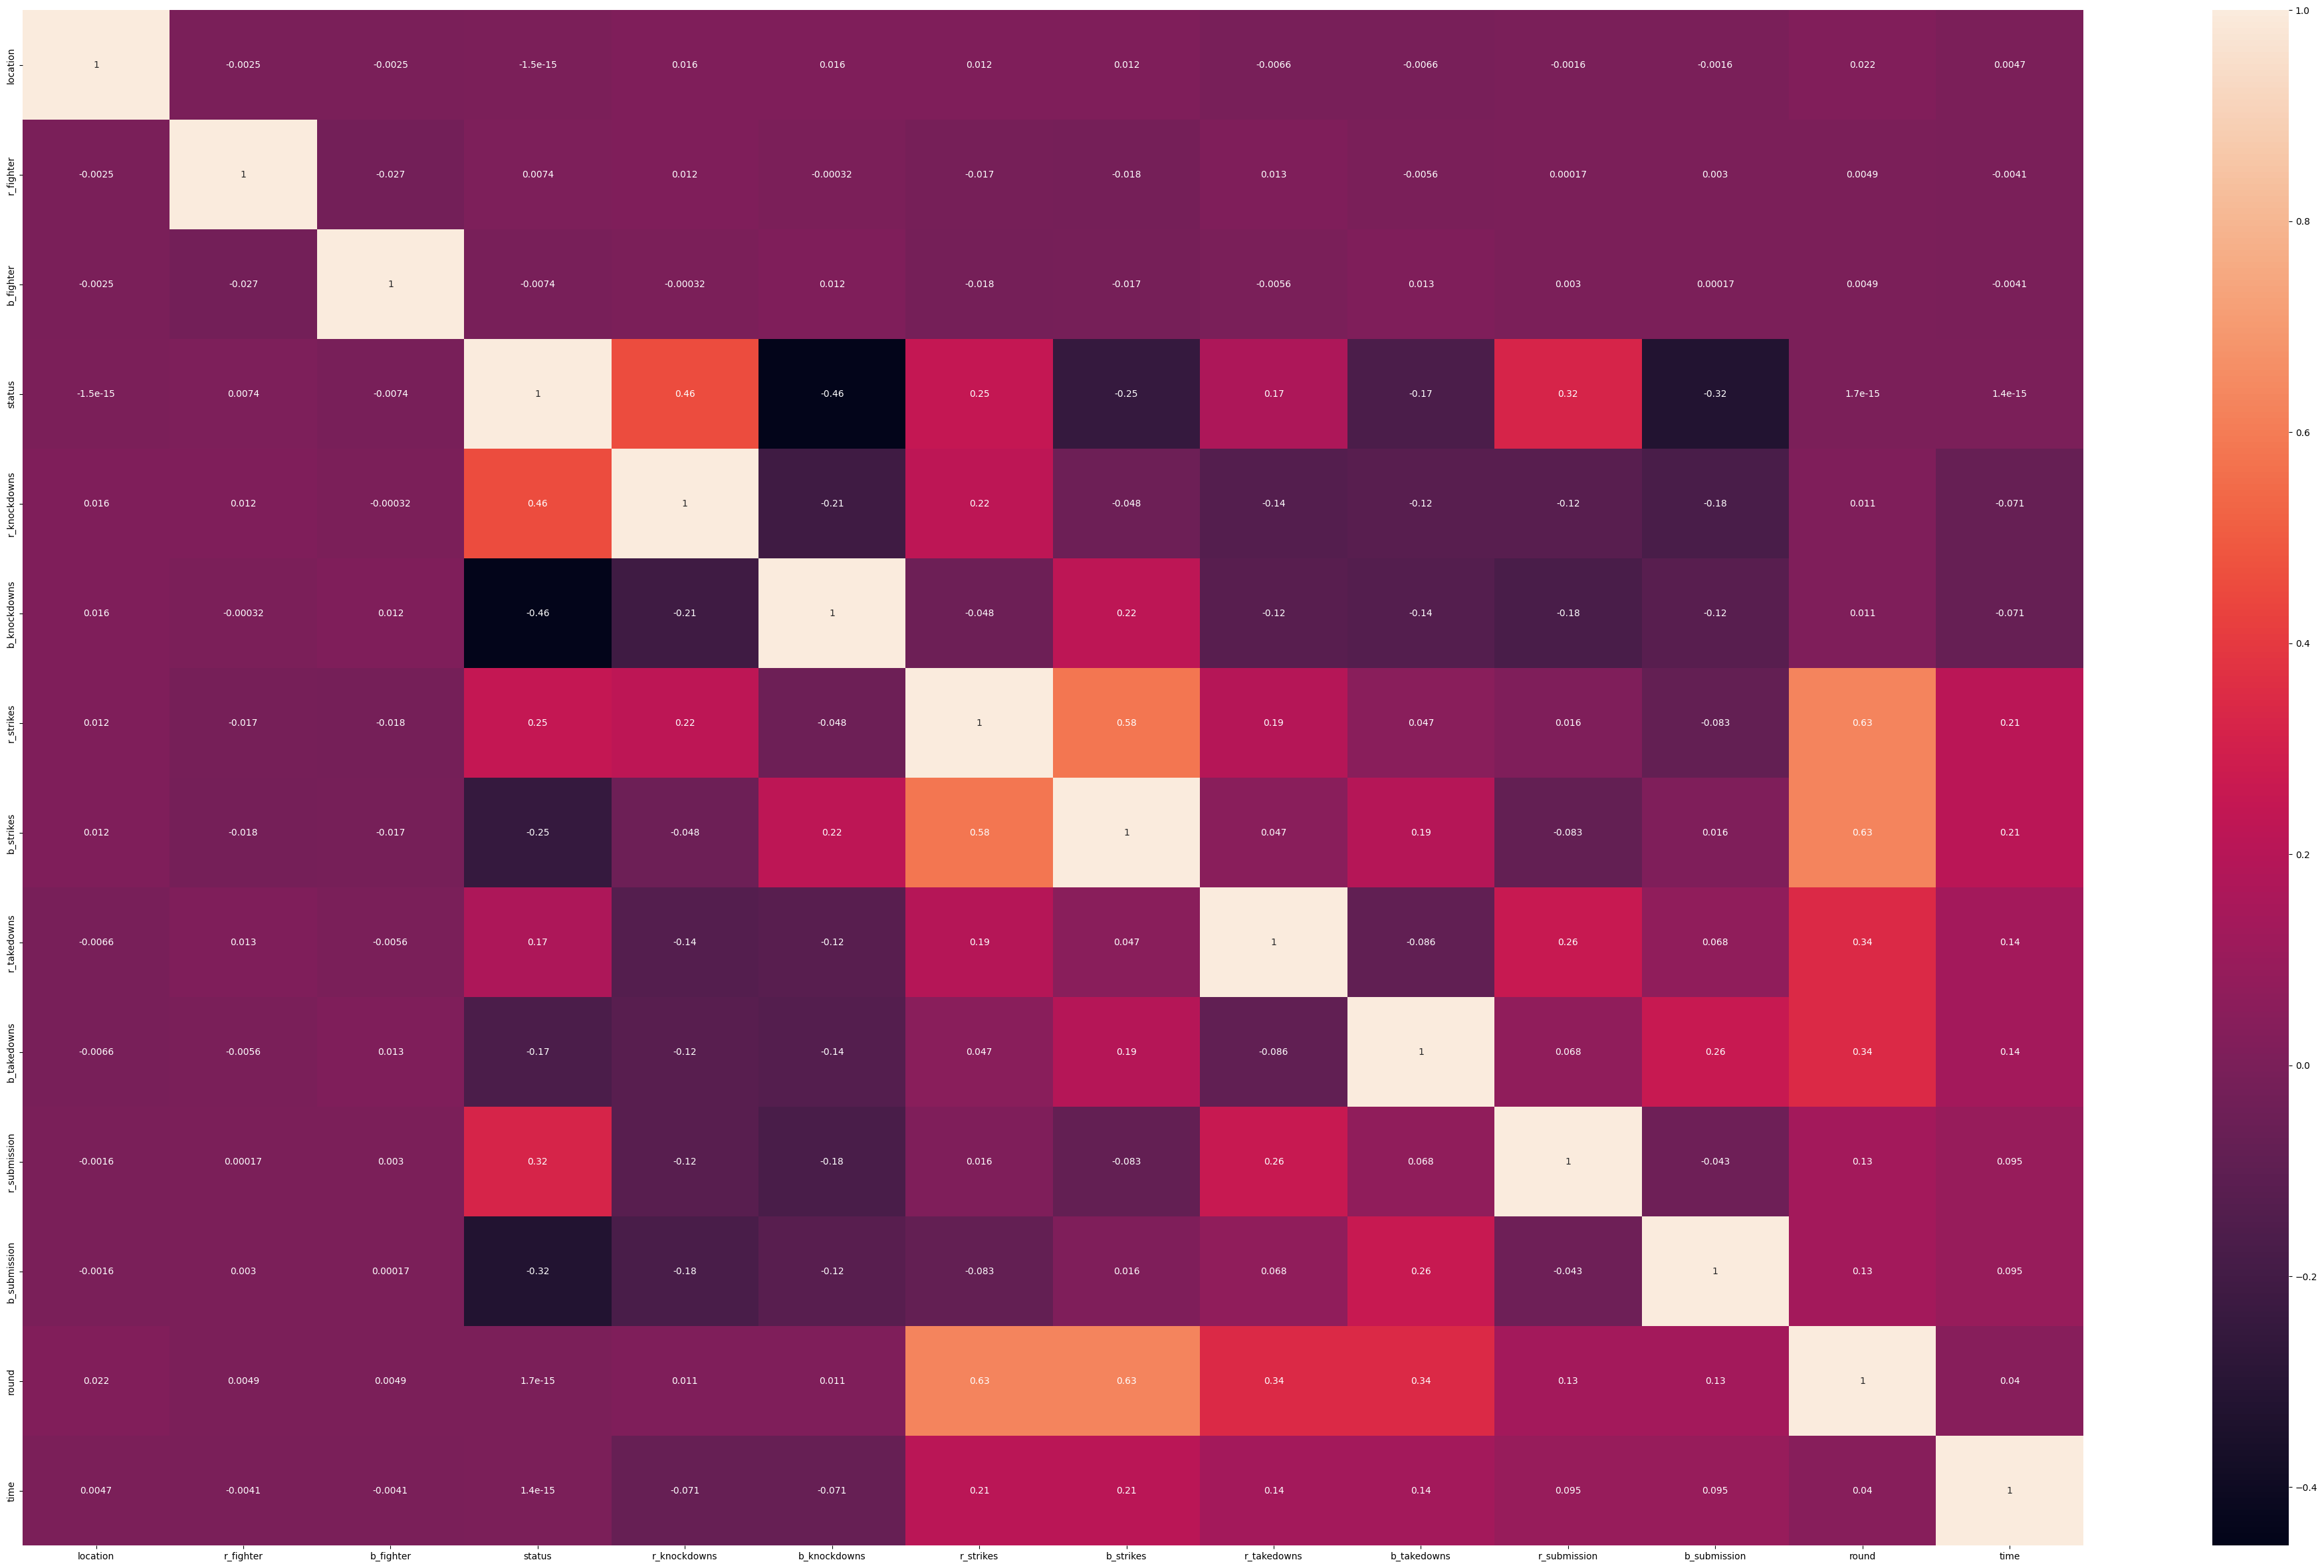

In [14]:
plt.figure(figsize=(50,30))
sns.heatmap(data.corr(),annot=True)

**TRAIN-TEST DATA SPLIT**

In [15]:
X = data.drop('status',axis=1)
y = data['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

**FEATURE NORMALIZATION**

In [16]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

**CUSTOM ERROR GRAPH PLLOTTING FUNCTION**

In [17]:
def plot_error_graph(y_test, y_pred):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    errors = {}

    for metric in metrics:
        # Calculate the error for each metric
        if metric == 'accuracy':
            error = 1 - accuracy_score(y_test, y_pred)
        elif metric == 'precision':
            error = 1 - precision_score(y_test, y_pred)
        elif metric == 'recall':
            error = 1 - recall_score(y_test, y_pred)
        elif metric == 'f1':
            error = 1 - f1_score(y_test, y_pred)
        else:
            raise ValueError("Invalid metric. Please choose from 'accuracy', 'precision', 'recall', or 'f1'.")

        errors[metric] = error

    # Plot all the errors
    for metric, error in errors.items():
        plt.plot(range(len(y_test)), [error] * len(y_test), label=f'{metric.capitalize()} Error')

    plt.xlabel('Data Points')
    plt.ylabel('Error')
    plt.title('Error Plot')
    plt.legend()
    plt.show()

**LOGISTIC REGRESSION**

In [18]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, **best_params)
best_log_reg.fit(X_train_scaled, y_train)

best_log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, **best_params)
best_log_reg.fit(X_train_scaled, y_train)

y_pred = best_log_reg.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best Hyperparameters: {'C': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       790
           1       0.93      0.95      0.94       740

    accuracy                           0.94      1530
   macro avg       0.94      0.94      0.94      1530
weighted avg       0.94      0.94      0.94      1530

Confusion Matrix:
[[739  51]
 [ 39 701]]


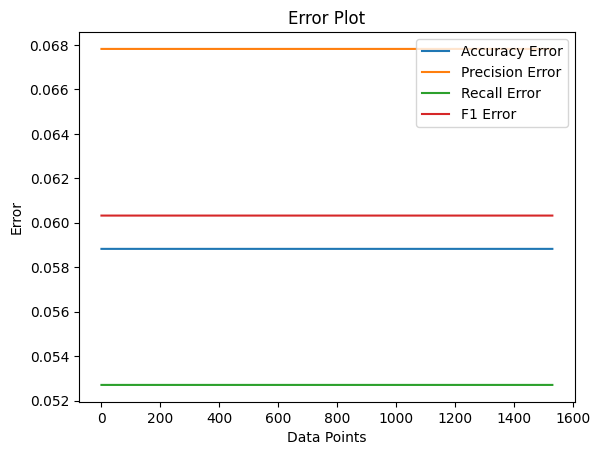

In [19]:
plot_error_graph(y_test, y_pred)

**NAIVE BAYES CLASSIFIER**

In [21]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

naive_bayes = GaussianNB()

param_grid = {}

grid_search_nb = GridSearchCV(naive_bayes, param_grid, cv=5, scoring=scoring, refit='f1_score')
grid_search_nb.fit(X_train_scaled, y_train)

best_nb = grid_search_nb.best_estimator_

y_pred_nb = best_nb.predict(X_test_scaled)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
f1_score_nb = f1_score(y_test, y_pred_nb, average='weighted')

print("Naive Bayes Classifier Metrics:")
print("Accuracy:", accuracy_nb)
print("Precision:", precision_nb)
print("Recall:", recall_nb)
print("F1-score:", f1_score_nb)

Naive Bayes Classifier Metrics:
Accuracy: 0.9130718954248366
Precision: 0.913461161414909
Recall: 0.9130718954248366
F1-score: 0.9130945184508741


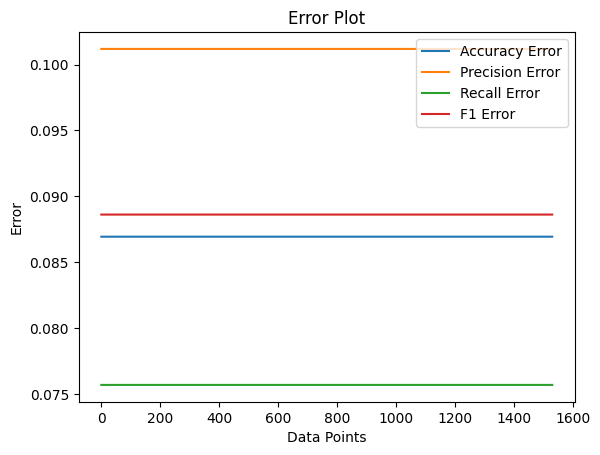

In [34]:
plot_error_graph(y_test, y_pred_nb)

**K NEAREST NEIGHBOR**

In [23]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='f1_score')
grid_search_knn.fit(X_train_scaled, y_train)

best_knn = grid_search_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_score_knn = f1_score(y_test, y_pred_knn, average='weighted')

print("k-Nearest Neighbors (KNN) Classifier Metrics:")
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1-score:", f1_score_knn)

k-Nearest Neighbors (KNN) Classifier Metrics:
Accuracy: 0.9235294117647059
Precision: 0.9235638614869708
Recall: 0.9235294117647059
F1-score: 0.9235367682426506


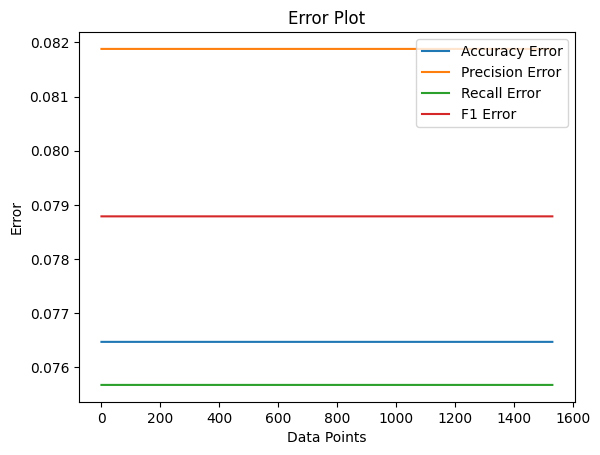

In [33]:
plot_error_graph(y_test, y_pred_knn)

**DECISION TREE**

In [25]:
decision_tree = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

grid_search_dt = GridSearchCV(decision_tree, param_grid, cv=5, scoring=scoring, refit='f1_score')
grid_search_dt.fit(X_train_scaled, y_train)

best_dt = grid_search_dt.best_estimator_

y_pred_dt = best_dt.predict(X_test_scaled)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_score_dt = f1_score(y_test, y_pred_dt, average='weighted')

print("Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1-score:", f1_score_dt)

Decision Tree Classifier Metrics:
Accuracy: 0.918954248366013
Precision: 0.9190824888875986
Recall: 0.918954248366013
F1-score: 0.9189176197753572


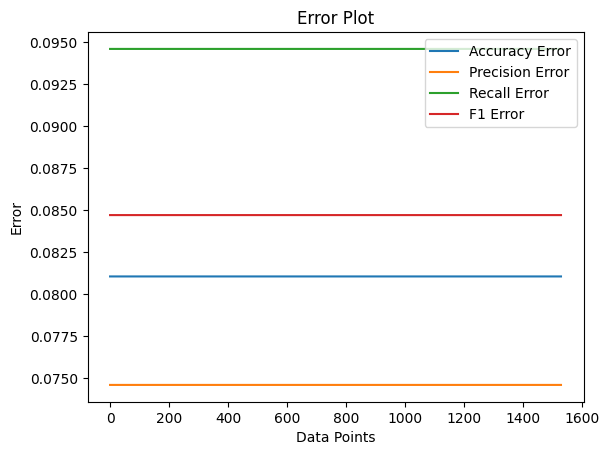

In [32]:
plot_error_graph(y_test, y_pred_dt)

**SUPPORT VECTOR MACHINE**

In [27]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring=scoring, refit='f1_score')
grid_search_svm.fit(X_train_scaled, y_train)

best_svm = grid_search_svm.best_estimator_

y_pred_svm = best_svm.predict(X_test_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_score_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("Support Vector Machine (SVM) Classifier Metrics:")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1-score:", f1_score_svm)

Support Vector Machine (SVM) Classifier Metrics:
Accuracy: 0.934640522875817
Precision: 0.9347810155439229
Recall: 0.934640522875817
F1-score: 0.9346532625561396


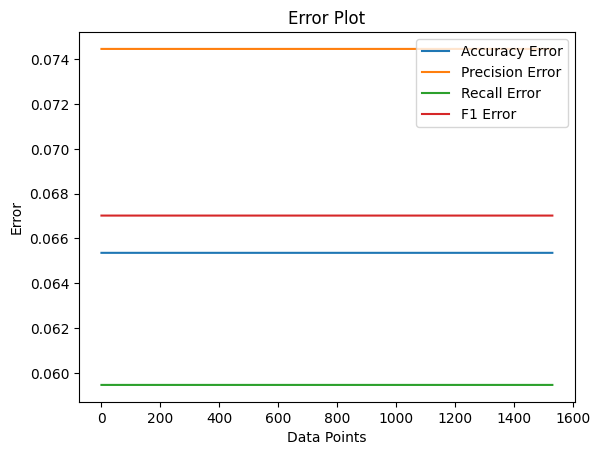

In [31]:
plot_error_graph(y_test, y_pred_svm)

**RANDOM FOREST CLASSIFIER**

In [29]:
random_forest = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

grid_search_rf = GridSearchCV(random_forest, param_grid, cv=5, scoring=scoring, refit='f1_score')
grid_search_rf.fit(X_train_scaled, y_train)

best_rf = grid_search_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_score_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest Classifier Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-score:", f1_score_rf)

Random Forest Classifier Metrics:
Accuracy: 0.9300653594771242
Precision: 0.9300630076404051
Recall: 0.9300653594771242
F1-score: 0.930060603628082


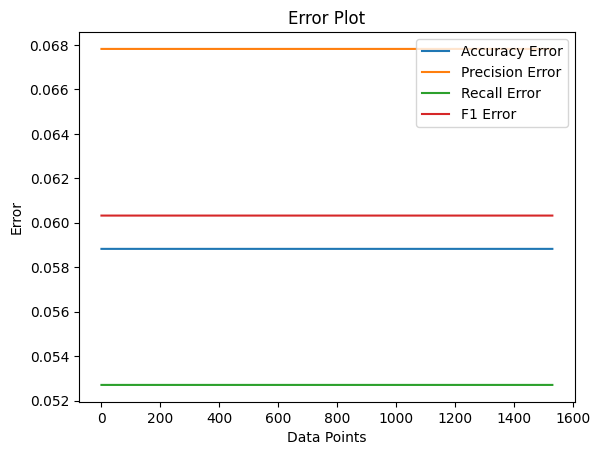

In [30]:
plot_error_graph(y_test, y_pred_rf)